In [1]:
import numpy as np
from matplotlib.ticker import MultipleLocator
from types import SimpleNamespace

%load_ext autoreload
%autoreload 2
# You can load your python module as this:
import Functions2021 as fun

# 1. Human capital accumulation

Consider a worker living in **two periods**, $t \in \{1,2\}$. 

In each period she decides whether to **work ($l_t = 1$) or not ($l_t = 0$)**. 

She can *not* borrow or save and thus **consumes all of her income** in each period. 

If she **works** her **consumption** becomes:

$$
c_t = w h_t l_t\;\;\text{if}\;\;l_t=1
$$

where $w$ is **the wage rate** and $h_t$ is her **human capital**. 

If she does **not work** her consumption becomes:

$$
c_t = b\;\;\text{if}\;\;l_t=0
$$

where $b$ is the **unemployment benefits**.

Her **utility of consumption** is: 

$$ 
\frac{c_t^{1-\rho}}{1-\rho} 
$$

Her **disutility of working** is:

$$ 
\gamma l_t 
$$

From period 1 to period 2, she **accumulates human capital** according to:

$$ 
\begin{aligned}
h_2 &= h_1 + l_1 + 
\begin{cases}
0 & \text{with prob. }0.5 \\
\Delta & \text{with prob. }0.5 
\end{cases}
\end{aligned}
$$

where $\Delta$ is a **stochastic experience gain**.

In the **second period** the worker thus solves:

$$
\begin{aligned}
v_{2}(h_{2}) & = \max_{l_{2}} \frac{c_2^{1-\rho}}{1-\rho} - \gamma l_2
\\ & \text{s.t.} & \\
c_{2}& = \begin{cases}
w h_2 & 
\text{if }l_2 = 1  \\
b & \text{if }l_2 = 0 
\end{cases} \\
l_{2}& \in \{0,1\}
\end{aligned}
$$

In the **first period** the worker thus solves:

$$
\begin{aligned}
v_{1}(h_{1}) &= \max_{l_{1}} \frac{c_1^{1-\rho}}{1-\rho} - \gamma l_1 + \beta\mathbb{E}_{1}\left[v_2(h_2)\right] \\ \text{s.t.} \\
c_{1}& = \begin{cases}
w h_1 & 
\text{if }l_1 = 1  \\
b & \text{if }l_1 = 0 
\end{cases} \\
h_2 &= h_1 + l_1 + \begin{cases}
0 & \text{with prob. }0.5\\
\Delta & \text{with prob. }0.5 
\end{cases}\\
l_{1} &\in \{0,1\}\\
\end{aligned}
$$

where $\beta$ is the **discount factor** and $\mathbb{E}_{1}\left[v_2(h_2)\right]$ is the **expected value of living in period two**.

The **parameters** of the model are:

In [2]:
rho = 2
beta = 0.96
gamma = 0.1
w = 2
b = 1
Delta = 0.1

The **relevant levels of human capital** are:

In [3]:
h_vec = np.linspace(0.1,1.5,100)

**Question 1:** Solve the model in period 2 and illustrate the solution (including labor supply as a function of human capital). 

In [4]:
x_format= lambda x,pos : f'{x:.2f}'
formatter= [MultipleLocator(0.2),x_format,MultipleLocator(0.2),x_format]

In [5]:
def u(c,rho):
    '''
    Utility_function
    Args:
        c (float)  : Amount consumed
        rho (float): Parameter
    
    returns:
        Utility of worker gained from comsumption
    
    '''
    if rho==1:
        return np.log(c)
    else:
        return c**(1-rho)/(1-rho)

def v2(c2,l2,gamma,rho):
    '''
    Total utility in period 2
    Args:
        c2 (float)   : Amount consumed in period 2
        l2 (int)     : Whether the worker works or not, in period 2
                       can either be 0 or 1. 
        gamma,rho (float): parameters
        
    Returns:
        v2 (float)   : Net utility in period 2. 
        
    '''
    v2 = u(c2,rho)-gamma*l2
    return v2

def eq_constraint(c2,w,h2,l2):
    return c2-w*h2*l2


In [6]:
def solve_period_2(h2_vec,b,rho,gamma,return_full=False):
    '''
    Solves the optimization problem for period two,
    e.g compares utility of the two possible scenarios,
    and chooses the highest utility.
    
    Args:
        h2_vec (array)      : Human capital of the worker
        b (float)           : Unemployment benefit if she decides not to work
        rho,gamma (floats)  : Parameters
        output_utility(bool): If True returns utility if False returns l2
        
    Returns:
        Utility (float) : Net utility in period 2
        l2 (int)        : Either 0 or 1, if 0 she decides not to work, if 1 she does work.
    
    '''
    shape = h2_vec.shape
    b_vec = np.full(shape,b,dtype=float)
    
    u_work = v2(w*h2_vec,1,gamma,rho)
    u_nowork = v2(b_vec,0,gamma,rho)
    u_vec = np.fmax(u_work,u_nowork)
    
    if return_full:
        l2_vec = np.array((u_work>u_nowork),dtype=int)
        return u_vec, l2_vec, u_work, u_nowork
        
    return u_vec

In [7]:
u2_vec, l2_vec, u2_work, u2_nowork = solve_period_2(h_vec,b,rho,gamma,return_full=True)

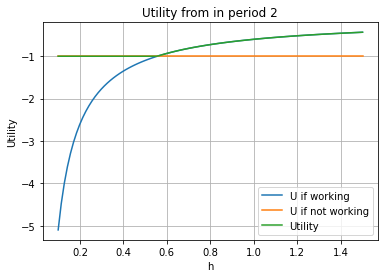

In [8]:
fig, ax = fun.plot('h',['U if working','U if not working','Utility'],h_vec,[u2_work,u2_nowork,u2_vec],'Utility',title ='Utility from in period 2')

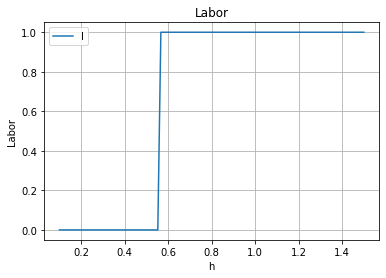

In [9]:
fig, ax = fun.plot('h',['l'],h_vec,[l2_vec],'Labor',title='Labor')

**Question 2:** Solve the model in period 1 and illustrate the solution (including labor supply as a function of human capital). 


In [10]:
from scipy import interpolate

In [11]:
def v1(c1,l1, h1 ,v2_interp, b,w,rho,beta,gamma,Delta):
    '''
    Calculates the expected utility from period 1
    
    Args:
        l1 (int)   : Either 0 (for not working) or 1 (for working)
        h1 (float) : Inital amount of human capital
        b (float)  : Unemployment benefits
        w (float)  : Standard wage rate (income is calculated as the products between this and human capital)
        rho,beta,gamma (floats) : Parameters
        Delta (float) : Stochatic increase in human capital (with probability 0.5)
        
    Returns:
        Utility (float): Expected utility in period 1
    
    '''
    
    # utility expected in period 2 is calculated as the mean of the two possible outcomes of increase in human capital:
    h2 = h1 + l1
    u2_good = v2_interp(h2+Delta)[0]
    u2_bad = v2_interp(h2+Delta)[0]
    expected_u2 = (u2_good+u2_bad)/2
    
    
    utility = u(c1,rho)-gamma*l1+beta*expected_u2
    return utility

In [12]:
def solve_period1(h1_vec,v2_interp,b,w,rho,beta,gamma,Delta,return_full=False):
    '''
    Solves the utility maximization problem in period 1, by comparing the two options
    of the worker, and choosing the highest utility.
    
    Args:
        Args:
        h1_vec (array) : Inital amount of human capital
        b (float)  : Unemployment benefits
        w (float)  : Standard wage rate (income is calculated as the products between this and human capital)
        rho,beta,gamma (floats) : Parameters
        Delta (float) : Stochatic increase in human capital (with probability 0.5)
        output_utility(bool): If True returns utility if False returns l1
    
    Returns:
        Utility (float) : Net utility in period 2
        l1 (int)        : Either 0 or 1, if 0 she decides not to work, if 1 she does work.
        
    '''
    shape = h1_vec.shape
    
    b_vec = np.full(shape,b,dtype=float)
    
    u_work = v1(w*h1_vec,1,h1_vec,v2_interp, b,w,rho,beta,gamma,Delta)
    u_nowork = v1(b_vec,0,h1_vec,v2_interp, b,w,rho,beta,gamma,Delta)
    u_vec = np.fmax(u_work,u_nowork)
    
    if return_full:
        l1_vec = np.array((u_work>u_nowork),dtype=int)
        return u_vec, l1_vec, u_work, u_nowork
        
    return u_vec

In [13]:
v2_interp = interpolate.RegularGridInterpolator((h_vec,), u2_vec,
                                                bounds_error=False,fill_value=None)


In [14]:
u1_vec, l1_vec, u1_work, u1_nowork = solve_period1(h_vec,v2_interp,b,w,rho,beta,gamma,Delta,return_full=True)

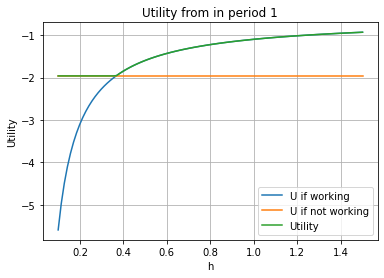

In [15]:
fig, ax = fun.plot('h',['U if working','U if not working','Utility'],h_vec,[u1_work,u1_nowork,u1_vec],'Utility',title ='Utility from in period 1')

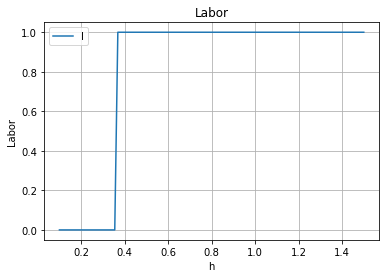

In [16]:
fig, ax = fun.plot('h',['l'],h_vec,[l1_vec],'Labor',title='Labor')

**Question 3:** Will the worker never work if her potential wage income is lower than the unemployment benefits she can get? Explain and illustrate why or why not.

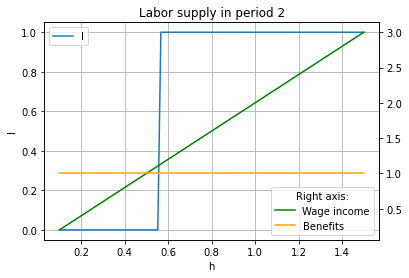

In [17]:
fig, ax = fun.plot('h',['l'],h_vec,[l2_vec],'l',title='Labor supply in period 2')
# twin object for two different y-axis on the sample plot

ax2=ax.twinx()
# make a plot with different y-axis using second axis object
w_vec = w*h_vec
b_vec = b_vec = np.full(h_vec.shape,b,dtype=float)
ax2.plot(h_vec,w_vec,color='green',label='Wage income')
ax2.plot(h_vec,b_vec,color='orange',label='Benefits')
ax2.legend(loc=4,title='Right axis:');

In period 2, it is clear that the worker will only work if wage are sufficiently higher than benifits to outweight the disutlity from working

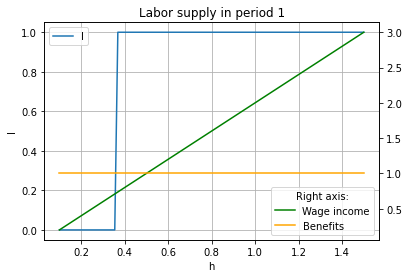

In [18]:
fig, ax = fun.plot('h',['l'],h_vec,[l1_vec],'l',title='Labor supply in period 1')
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
w_vec = w*h_vec
b_vec = b_vec = np.full(h_vec.shape,b,dtype=float)
ax2.plot(h_vec,w_vec,color='green',label='Wage income')
ax2.plot(h_vec,b_vec,color='orange',label='Benefits')
ax2.legend(loc=4,title='Right axis:');

For period 1, the workers starts working before wages are higher than benefits. This is because working increases the workers' human capital, increasing wage income in period 2. 

# 2. AS-AD model

Consider the following **AS-AD model**. The **goods market equilibrium** is given by

$$ 
y_{t} = -\alpha r_{t} + v_{t} 
$$

where $y_{t}$ is the **output gap**, $r_{t}$ is the **ex ante real interest** and $v_{t}$ is a **demand disturbance**. 

The central bank's **Taylor rule** is

$$ 
i_{t} = \pi_{t+1}^{e} + h \pi_{t} + b y_{t}
$$

where $i_{t}$ is the **nominal interest rate**, $\pi_{t}$ is the **inflation gap**, and $\pi_{t+1}^{e}$ is the **expected inflation gap**. 

The **ex ante real interest rate** is given by 

$$
r_{t} = i_{t} - \pi_{t+1}^{e}
$$

Together, the above implies that the **AD-curve** is

$$
\pi_{t} = \frac{1}{h\alpha}\left[v_{t} - (1+b\alpha)y_{t}\right]
$$

Further, assume that the **short-run supply curve (SRAS)** is given by

$$
\pi_{t} = \pi_{t}^{e} + \gamma y_{t} + s_{t}
$$

where $s_t$ is a **supply disturbance**.

**Inflation expectations are adaptive** and given by

$$
\pi_{t}^{e} = \phi\pi_{t-1}^{e} + (1-\phi)\pi_{t-1}
$$

Together, this implies that the **SRAS-curve** can also be written as

$$
\pi_{t} = \pi_{t-1} + \gamma y_{t} - \phi\gamma y_{t-1} + s_{t} - \phi s_{t-1}
$$

The **parameters** of the model are:

In [19]:
par = {}

par['alpha'] = 5.76
par['h'] = 0.5
par['b'] = 0.5
par['phi'] = 0
par['gamma'] = 0.075

**Question 1:** Use the ``sympy`` module to solve for the equilibrium values of output, $y_t$, and inflation, $\pi_t$, (where AD = SRAS) given the parameters ($\alpha$, $h$, $b$, $\alpha$, $\gamma$) and $y_{t-1}$ , $\pi_{t-1}$, $v_t$, $s_t$, and $s_{t-1}$.

In [20]:
import sympy as sm

In [21]:
#Initiate variables
pi_t = sm.symbols('\pi_{t}')
h = sm.symbols('h')
alpha = sm.symbols('\\alpha')
v_t = sm.symbols('v_{t}')
b = sm.symbols('b')
y_t = sm.symbols('y_{t}')
y_t1 = sm.symbols('y_{t-1}')
pi_t1 = sm.symbols('\pi_{t-1}')
gamma = sm.symbols('\gamma')
phi = sm.symbols('phi')
s_t = sm.symbols('s_t')
s_t1 = sm.symbols('s_{t-1}')

In [22]:
ad = sm.Eq(pi_t,1/(h*alpha)*(v_t-(1+b*alpha)*y_t))
ad

Eq(\pi_{t}, (v_{t} - y_{t}*(\alpha*b + 1))/(\alpha*h))

In [23]:
sras =sm.Eq(pi_t,pi_t1+gamma*y_t-phi*gamma*y_t1+s_t-phi*s_t1)
sras

Eq(\pi_{t}, -\gamma*phi*y_{t-1} + \gamma*y_{t} + \pi_{t-1} - phi*s_{t-1} + s_t)

In [24]:
# Set pi_ad = pi_sras
pi_from_ad = ad.rhs
equilibrium_y = sras.subs(pi_t,pi_from_ad)
equilibrium_y

Eq((v_{t} - y_{t}*(\alpha*b + 1))/(\alpha*h), -\gamma*phi*y_{t-1} + \gamma*y_{t} + \pi_{t-1} - phi*s_{t-1} + s_t)

And solve for $y$ and $\pi$ : 

In [25]:
y_eq = sm.solve(equilibrium_y,y_t)[0]
y_equation = sm.Eq(y_t,y_eq)
# define as python function:
_y_equilibrium = sm.lambdify((y_t1,pi_t1,v_t,s_t,s_t1,alpha,gamma,h,b,phi),y_eq)

# print our solution symbolicaly 
y_equation

Eq(y_{t}, (\alpha*\gamma*h*phi*y_{t-1} - \alpha*\pi_{t-1}*h + \alpha*h*phi*s_{t-1} - \alpha*h*s_t + v_{t})/(\alpha*\gamma*h + \alpha*b + 1))

In [26]:
equilibrium_pi_equation = ad.subs(y_t,y_eq)
pi_equation = sm.Eq(pi_t,sm.solve(equilibrium_pi_equation,pi_t)[0])
# define as python function:
_pi_equilibrium = sm.lambdify((y_t1,pi_t1,v_t,s_t,s_t1,alpha,gamma,h,b,phi),sm.solve(equilibrium_pi_equation,pi_t)[0])
# print our solution symbolicaly 
pi_equation

Eq(\pi_{t}, (-\alpha*\gamma*b*phi*y_{t-1} + \alpha*\pi_{t-1}*b - \alpha*b*phi*s_{t-1} + \alpha*b*s_t - \gamma*phi*y_{t-1} + \gamma*v_{t} + \pi_{t-1} - phi*s_{t-1} + s_t)/(\alpha*\gamma*h + \alpha*b + 1))

**Question 2:** Find and illustrate the equilibrium when $y_{t-1} = \pi_{t-1} = v_t = s_t = s_{t-1} = 0$. Illustrate how the equilibrium changes when instead $v_t = 0.1$.

In [27]:
# Create dictionary for substuting in 0
vars_0 = {}
for var in [y_t1,pi_t1,v_t,s_t,s_t1]:
    vars_0[var]=0
    
y_equation.subs(vars_0)

Eq(y_{t}, 0)

In [28]:
pi_equation.subs(vars_0)

Eq(\pi_{t}, 0)

In [29]:
# Now for v_t =0.1:
vars_0[v_t]=0.1
y_v1 = y_equation.subs(vars_0)
y_v1

Eq(y_{t}, 0.1/(\alpha*\gamma*h + \alpha*b + 1))

In [30]:
pi_v1 = pi_equation.subs(vars_0)
pi_v1

Eq(\pi_{t}, 0.1*\gamma/(\alpha*\gamma*h + \alpha*b + 1))

In [31]:
# Count numerical answer from analytical solution:
paras = {}
for var, value in zip([alpha,gamma,h,b],[par['alpha'],par['gamma'],par['h'],par['b']]):
    paras[var]=value
y_v1.subs(paras)

Eq(y_{t}, 0.0244140625)

In [32]:
pi_v1.subs(paras)

Eq(\pi_{t}, 0.0018310546875)

In [33]:
# Redifine function ot take in shocks and par
y_equilibrium = fun.redefine_fun(_y_equilibrium)

# No shock should be zero
assert y_equilibrium(0,0,0,0,0,par)==0

# with shock is correct
y_equilibrium(0,0,0.1,0,0,par)

0.0244140625

In [34]:
pi_equilibrium = fun.redefine_fun(_pi_equilibrium)


# No shock should be zero
assert pi_equilibrium(0,0,0,0,0,par)==0
# with shock is correct
pi_equilibrium(0,0,0.1,0,0,par)

0.0018310546875

In [35]:
y_gaps = np.linspace(-0.01,0.03,100)

#We find the ad-and sras curves: 
# period 0:
ad = fun.ad(y_gaps,0,par)
sras = fun.sras(y_gaps,0,0,0,0,par)
# period 1:
ad1 = fun.ad(y_gaps,0.1,par)

''

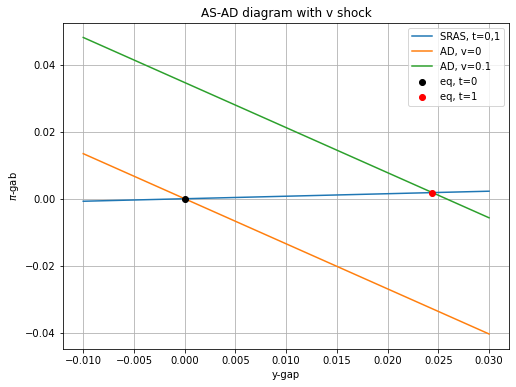

In [36]:
fig, ax = fun.plot('y-gap',['SRAS,t=0,1','AD, v=0','AD, v=0.1'],y_gaps,[sras, ad, ad1],'$\pi$-gab',title='AS-AD diagram with v shock',figsize=(8,6))
ax.scatter(0,0,label='Equilibrium',color='black',zorder=10)
ax.scatter(y_equilibrium(0,0,0.1,0,0,par),pi_equilibrium(0,0,0.1,0,0,par),label='Equilibrium',color='red',zorder=10)
ax.legend(['SRAS, t=0,1','AD, v=0','AD, v=0.1','eq, t=0','eq, t=1'])
;

In [119]:
## Extra, interactive:

from ipywidgets import interact
import ipywidgets as widgets

In [120]:
# we find equilibrium path
T = 100
pis = [0,pi_equilibrium(0,0,0.1,0,0,par)]
ys = [0,y_equilibrium(0,0,0.1,0,0,par)]

for i in range(1,T):
    # Caluclate lagged variables
    ys.append(y_equilibrium(ys[-1],pis[-1],0,0,0,par))
    pis.append(pi_equilibrium(ys[-1],pis[-1],0,0,0,par))

In [121]:
#  Calculate curves at each point in time
ad_curve = fun.ad(y_gaps,0,par)
ad_curves = [ad_curve for i in range(T+1)]
ad_curves[1] = fun.ad(y_gaps,0.1,par)

sras_curves = [fun.sras(y_gaps,0,0,0,0,par)]

for i in range(T+1):
    sras_curves.append(fun.sras(y_gaps,ys[i],pis[i],0,0,par))

In [122]:
def interactive_figure(t,title,data):
    # Unpack
    sras_curves, ad_curves, ys, pis,y_gaps = data
    
    # Calculate SRAS in period t:
    
    sras_t = sras_curves[t]
    ad_t   = ad_curves[t]
    
    fig, ax = fun.plot('y-gap',['SRAS,t=0,1','AD, v=0','AD, v=0.1'],y_gaps,[sras_curves[0], ad_curves[0], ad_curves[1]],'$\pi$-gab',title=title,figsize=(10,8))
    ax.scatter(ys[0],pis[0],label='Equilibrium',color='black',zorder=10)
    ax.scatter(ys[1],pis[1],label='Equilibrium',color='purple',zorder=10)
    
    ax.plot(y_gaps,sras_t,color='darkblue',linestyle='--',zorder=11)
    ax.plot(y_gaps,ad_t,color='darkgreen',linestyle='--',zorder=11)
    
    ax.scatter(ys[t],pis[t],color='red',zorder=12)
    
    ax.legend(['SRAS, t=0,1','AD, v=0','AD, v=0.1',f'SRAS, t={t}',f'AD, t={t}','eq, t=0','eq, t=1',f'eq t={t}']);


In [132]:
interact(interactive_figure, t=widgets.IntSlider(min=1,max=50,step=1,value=1,layout=widgets.Layout(width='30%')),
        title=widgets.fixed('AS-AD diagram with v shock in period 1, zero otherwise'),
        data = widgets.fixed([sras_curves, ad_curves, ys, pis,y_gaps]));

interactive(children=(IntSlider(value=1, description='t', layout=Layout(width='30%'), max=50, min=1), Output()…

**Persistent disturbances:** Now, additionaly, assume that both the demand and the supply disturbances are AR(1) processes

$$ 
\begin{aligned}
v_{t} &= \delta v_{t-1} + x_{t} \\
s_{t} &= \omega s_{t-1} + c_{t} 
\end{aligned}
$$

where $x_{t}$ is a **demand shock**, and $c_t$ is a **supply shock**. The **autoregressive parameters** are:

In [124]:
par['delta'] = 0.80
par['omega'] = 0.15

**Question 3:** Starting from $y_{-1} = \pi_{-1} = s_{-1} = 0$, how does the economy evolve for $x_0 = 0.1$, $x_t = 0, \forall t > 0$ and $c_t = 0, \forall t \geq 0$?

First we look at period 0 and 1 

In [125]:
v0 = fun.d_pers(0,0.1,par)
y0 = y_equilibrium(0,0,v0,0,0,par)
pi0 = pi_equilibrium(0,0,v0,0,0,par)
print(f'Outputgab in period 0 is    {y0:.4f}')
print(f'Inflationgab in period 0 is {pi0:.4f}')

Outputgab in period 0 is    0.0244
Inflationgab in period 0 is 0.0018


In [126]:
v1 = fun.d_pers(v0,0,par)
y1 = y_equilibrium(y0,pi0,v1,0,0,par)
pi1 = pi_equilibrium(y0,pi0,v1,0,0,par)
print(f'Outputgab in period 1 is    {y1:.4f}')
print(f'Inflationgab in period 1 is {pi1:.4f}')

Outputgab in period 1 is    0.0182
Inflationgab in period 1 is 0.0032


In [127]:
T = 100
vs = [0,v0]
ys2 = [0,y0]
pis2= [0,pi0]

for i in range(1,T):
    vs.append(fun.d_pers(vs[i],0,par))
    ys2.append(y_equilibrium(ys2[i],pis2[i],vs[i+1],0,0,par))
    pis2.append(pi_equilibrium(ys2[i],pis2[i],vs[i+1],0,0,par))
    
zeros = [0 for i in range(0,T+1)]

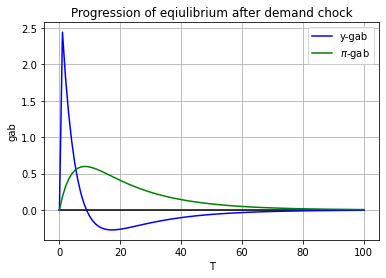

In [128]:
fig, ax = fun.plot('T',['','y-gab','$\pi$-gab'],range(0,T+1),[zeros,[y*100 for y in ys2],[pi*100 for pi in pis2]],'gab',
                   y_colors = ['black','blue','green'],title='Progression of eqiulibrium after demand chock')

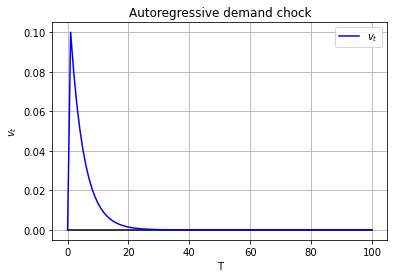

In [129]:
fig, ax = fun.plot('T',['','$v_{t}$'],range(0,T+1),[zeros,vs],'$v_{t}$',
                   y_colors = ['black','blue'],title='Autoregressive demand chock')

Now the entire AD-AS plot

In [130]:
y_gaps2 = np.linspace(-0.02,0.05,100)


#  Calculate curves at each point in time
ad_curves2 = [fun.ad(y_gaps2,v,par) for v in vs]
sras_curves2 = [fun.sras(y_gaps2,0,0,0,0,par)]
for i in range(T+1):
    sras_curves2.append(fun.sras(y_gaps2,ys2[i],pis2[i],0,0,par))

In [131]:
interact(interactive_figure, t=widgets.IntSlider(min=1,max=t,step=1,value=1,layout=widgets.Layout(width='30%')),
        title=widgets.fixed('AS-AD diagram with Autoregressive demand chock in period 1'),
        data = widgets.fixed([sras_curves2, ad_curves2, ys2, pis2, y_gaps2]));

interactive(children=(IntSlider(value=1, description='t', layout=Layout(width='30%'), min=1), Output()), _dom_…

With a autoregressive shock, the adaptive $\pi$-expectations are consistently exceeded, leading to a rising $\pi$-gap until around period 8, the high $\pi$-expectations causes a negative y-gap as the economy re-converges

**Stochastic shocks:** Now, additionally, assume that $x_t$ and $c_t$ are stochastic and normally distributed

$$ 
\begin{aligned}
x_{t}&\sim\mathcal{N}(0,\sigma_{x}^{2}) \\
c_{t}&\sim\mathcal{N}(0,\sigma_{c}^{2}) \\
\end{aligned}
$$

The **standard deviations of the shocks** are:

In [6]:
par['sigma_x'] = 3.492
par['sigma_c'] = 0.2

**Question 4:** Simulate the AS-AD model for 1,000 periods. Calculate the following five statistics:

1. Variance of $y_t$, $var(y_t)$
2. Variance of $\pi_t$, $var(\pi_t)$
3. Correlation between $y_t$ and $\pi_t$, $corr(y_t,\pi_t)$
4. Auto-correlation between $y_t$ and $y_{t-1}$, $corr(y_t,y_{t-1})$
5. Auto-correlation between $\pi_t$ and $\pi_{t-1}$, $corr(\pi_t,\pi_{t-1})$

**Question 5:** Plot how the correlation between $y_t$ and $\pi_t$ changes with $\phi$. Use a numerical optimizer or root finder to choose $\phi\in(0,1)$ such that the simulated correlation between $y_t$ and $\pi_t$ comes close to 0.31. 

**Quesiton 6:** Use a numerical optimizer to choose $\sigma_x>0$, $\sigma_c>0$ and $\phi\in(0,1)$ to make the simulated statistics as close as possible to US business cycle data where:

1. $var(y_t) = 1.64$
2. $var(\pi_t) = 0.21$
3. $corr(y_t,\pi_t) = 0.31$
4. $corr(y_t,y_{t-1}) = 0.84$
5. $corr(\pi_t,\pi_{t-1}) = 0.48$

# 3. Exchange economy

Consider an **exchange economy** with

1. 3 goods, $(x_1,x_2,x_3)$
2. $N$ consumers indexed by $j \in \{1,2,\dots,N\}$
3. Preferences are Cobb-Douglas with log-normally distributed coefficients

    $$ 
    \begin{aligned}
    u^{j}(x_{1},x_{2},x_{3}) &=
    \left(x_{1}^{\beta_{1}^{j}}x_{2}^{\beta_{2}^{j}}x_{3}^{\beta_{3}^{j}}\right)^{\gamma}\\
     \beta_{i}^{j} &= \frac{\alpha_{i}^{j}}{\alpha_{1}^{j}+\alpha_{2}^{j}+\alpha_{3}^{j}} \\
     \boldsymbol{\alpha}^{j} &= (\alpha_{1}^{j},\alpha_{2}^{j},\alpha_{3}^{j}) \\ 
     \log(\boldsymbol{\alpha}^j) &\sim \mathcal{N}(\mu,\Sigma) \\
    \end{aligned} 
    $$

4. Endowments are exponentially distributed,

$$
\begin{aligned}
\boldsymbol{e}^{j} &= (e_{1}^{j},e_{2}^{j},e_{3}^{j}) \\
 & e_i^j \sim f, f(z;\zeta) =  1/\zeta \exp(-z/\zeta)
\end{aligned}
$$

Let $p_3 = 1$ be the **numeraire**. The implied **demand functions** are:

$$
\begin{aligned}
x_{i}^{\star j}(p_{1},p_{2},\boldsymbol{e}^{j}) &= \beta^{j}_i\frac{I^j}{p_{i}} \\
\end{aligned}
$$

where consumer $j$'s income is

$$
I^j = p_1 e_1^j + p_2 e_2^j +p_3 e_3^j
$$

The **parameters** and **random preferences and endowments** are given by:

In [7]:
# a. parameters
N = 50000
mu = np.array([3,2,1])
Sigma = np.array([[0.25, 0, 0], [0, 0.25, 0], [0, 0, 0.25]])
gamma = 0.8
zeta = 1

# b. random draws
seed = 1986
np.random.seed(seed)

# preferences
alphas = np.exp(np.random.multivariate_normal(mu, Sigma, size=N))
betas = alphas/np.reshape(np.sum(alphas,axis=1),(N,1))

# endowments
e1 = np.random.exponential(zeta,size=N)
e2 = np.random.exponential(zeta,size=N)
e3 = np.random.exponential(zeta,size=N)

**Question 1:** Plot the histograms of the budget shares for each good across agents.

Consider the **excess demand functions:**

$$ 
z_i(p_1,p_2) = \sum_{j=1}^N x_{i}^{\star j}(p_{1},p_{2},\boldsymbol{e}^{j}) - e_i^j
$$

**Question 2:** Plot the excess demand functions.

**Question 3:** Find the Walras-equilibrium prices, $(p_1,p_2)$, where both excess demands are (approximately) zero, e.g. by using the following tâtonnement process:

1. Guess on $p_1 > 0$, $p_2 > 0$ and choose tolerance $\epsilon > 0$ and adjustment aggressivity parameter, $\kappa > 0$.
2. Calculate $z_1(p_1,p_2)$ and $z_2(p_1,p_2)$.
3. If $|z_1| < \epsilon$ and $|z_2| < \epsilon$ then stop.
4. Else set $p_1 = p_1 + \kappa \frac{z_1}{N}$ and $p_2 = p_2 + \kappa \frac{z_2}{N}$ and return to step 2.

**Question 4:** Plot the distribution of utility in the Walras-equilibrium and calculate its mean and variance.

**Question 5:** Find the Walras-equilibrium prices if instead all endowments were distributed equally. Discuss the implied changes in the distribution of utility. Does the value of $\gamma$ play a role for your conclusions?